In [1]:
%%capture
import sys

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

In [3]:
import pandas as pd

In [4]:
df=pd.read_csv("/Users/huanqingxu/Desktop/apple-app/app_train.csv" )

In [5]:
import pandas_profiling
df.profile_report()

In [6]:
#target

In [7]:
y=df['rating']

In [8]:
y.nunique()

2

In [9]:
#  There are 2 classes, this is a binary classification problem.

In [10]:
y.value_counts(normalize=True).max()

0.565133730998653

In [11]:
#select features

In [12]:
target='rating'
df_features= df.drop(columns=[target,'currency'])
numeric_features= df_features.select_dtypes(include='number').columns.tolist()
cardinality= df_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
features= numeric_features + categorical_features

In [13]:
features

['id',
 'size_bytes',
 'price',
 'rating_count_tot',
 'rating_count_ver',
 'sup_devices.num',
 'ipadSc_urls.num',
 'lang.num',
 'vpp_lic',
 'cont_rating',
 'prime_genre']

In [14]:
X = df[features]
y = df[target]

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)



In [17]:
 X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [18]:
X_train.shape,X_val.shape,X_test.shape

((3325, 11), (832, 11), (1040, 11))

In [19]:
#fit a linear model

In [20]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [21]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [22]:
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [24]:
model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.6298076923076923


In [25]:
# fit tree based model

In [26]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

In [27]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=3)
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.671875


In [28]:
# "The ROC curve is created by plotting the true positive rate (TPR)
# against the false positive (FPR)
# at various threshold settings."

# Use scikit-learn to calculate TPR & FPT at various thresholds
from sklearn.metrics import roc_curve
y_pred_proba = pipeline.predict_proba(X_val)[:, -1] # Probability for the last class
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [29]:
# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,1.770865
1,0.101810,0.325641,0.770865
2,0.201357,0.528205,0.601810
3,0.429864,0.761538,0.426193
4,0.687783,0.969231,0.300824
5,0.751131,1.000000,0.223684
6,1.000000,1.000000,0.000000


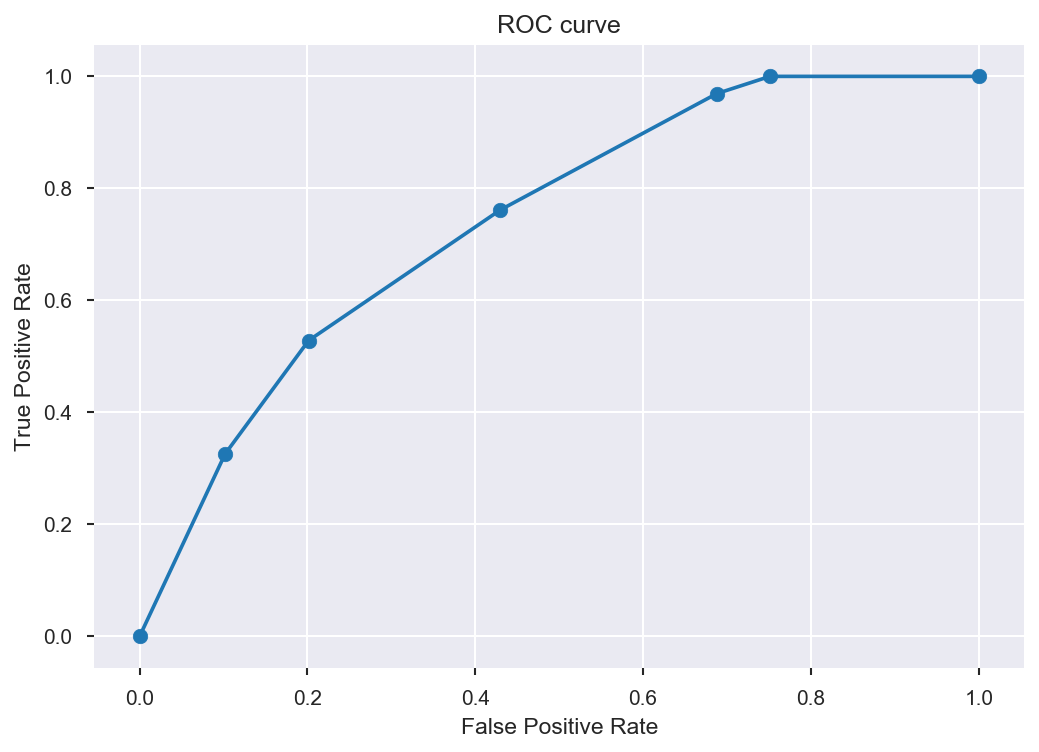

In [30]:
# See the results on a plot.
# This is the "Receiver Operating Characteristic curve"
import matplotlib.pyplot as plt
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [31]:
# Use scikit-learn to calculate the area under the curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val,y_pred_proba)

0.7408748114630468

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [33]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1)
)

pipeline.fit(X_train,y_train)
print('Validation Accuracy', pipeline.score(X_val,y_val))

Validation Accuracy 0.7043269230769231


In [34]:
print('Test Accuracy', pipeline.score(X_test,y_test))

Validation Accuracy 0.7163461538461539


In [35]:
y_pred = pipeline.predict(X_val)

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[348,  94],
       [152, 238]])

In [37]:
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array([0, 1])

In [38]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    return columns, index

plot_confusion_matrix(y_val, y_pred)

(['Predicted 0', 'Predicted 1'], ['Actual 0', 'Actual 1'])

In [39]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return table

plot_confusion_matrix(y_val, y_pred)

,Predicted 0,Predicted 1
Actual 0,348,94
Actual 1,152,238


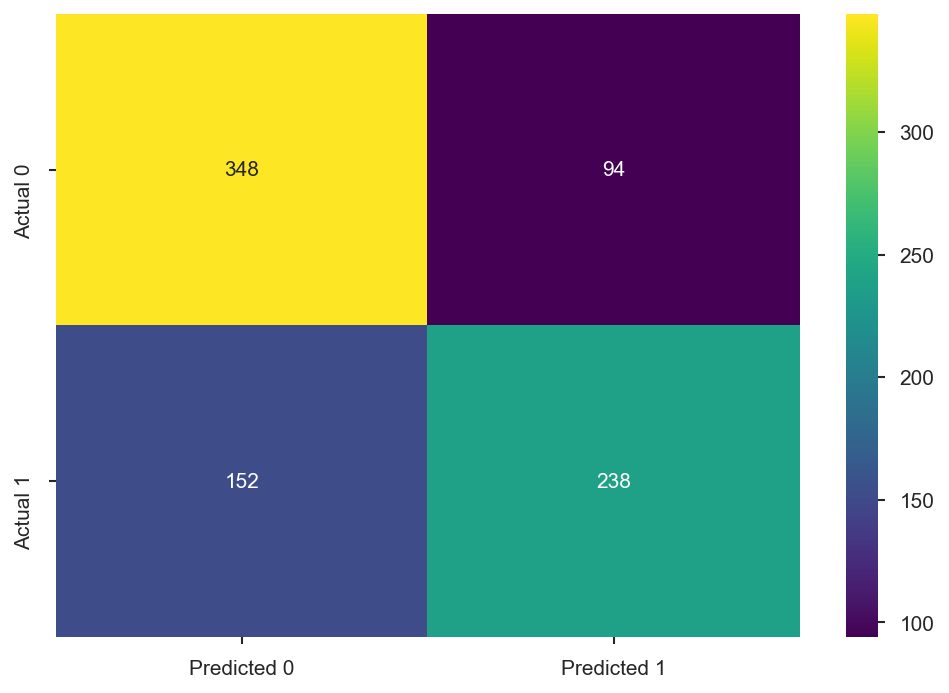

In [40]:
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_val, y_pred);

In [41]:
transformers=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

In [42]:
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed= transformers.transform(X_val)
model = RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1)
model.fit(X_train_transformed,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [43]:
import eli5
from eli5.sklearn import PermutationImportance

In [44]:
permuter= PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed,y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [45]:
feature_names=X_val.columns.tolist()
pd.Series(permuter.feature_importances_,feature_names).sort_values()

vpp_lic             0.000000
cont_rating         0.000240
sup_devices.num     0.006490
ipadSc_urls.num     0.007212
size_bytes          0.008654
lang.num            0.008654
prime_genre         0.011779
price               0.018029
rating_count_ver    0.021394
id                  0.035337
rating_count_tot    0.126683
dtype: float64

In [46]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.1267 ± 0.0194,rating_count_tot
0.0353 ± 0.0188,id
0.0214 ± 0.0130,rating_count_ver
0.0180 ± 0.0100,price
0.0118 ± 0.0155,prime_genre
0.0087 ± 0.0085,lang.num
0.0087 ± 0.0138,size_bytes
0.0072 ± 0.0065,ipadSc_urls.num
0.0065 ± 0.0084,sup_devices.num
0.0002 ± 0.0062,cont_rating


In [47]:
minimum_importance=0
mask=permuter.feature_importances_ > minimum_importance
features=X_train.columns[mask]
X_train= X_train[features]

In [48]:
X_val=X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1)
)

pipeline.fit(X_train,y_train)
print('Validation Accuracy', pipeline.score(X_val,y_val))

Validation Accuracy 0.7067307692307693


In [49]:
#fit Xgboost

In [50]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['cont_rating', 'prime_genre'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'cont_rating',
                                          'data_type': dtype('O'),
                                          'mapping': 4+     1
9+     2
12+    3
17+    4
NaN   -2
dtype: int64},
                                         {'col': 'prime_genre',
                                          'data_type': dtype('O'),
                                          'mapping': Games                 1
Utilities             2
Lifestyle             3
Entertainmen...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
        

In [51]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.7103365384615384


In [52]:
# partial Dependence plots with 1 feature

In [53]:
X=X_train
y=y_train
encoder=ce.OrdinalEncoder()
X_encoded=encoder.fit_transform(X)
model=RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1)
model.fit(X_encoded,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

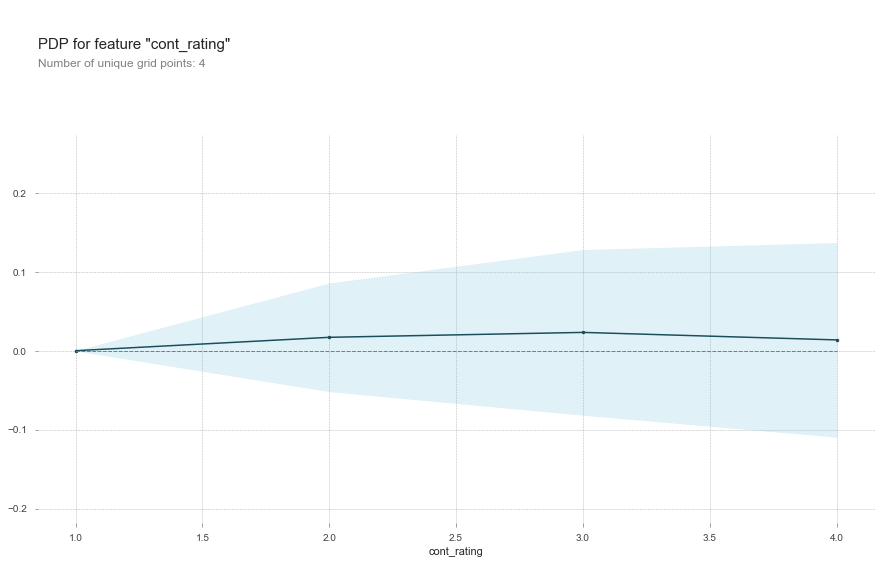

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'cont_rating'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [55]:
encoder.mapping

[{'col': 'cont_rating', 'mapping': 4+     1
  9+     2
  12+    3
  17+    4
  NaN   -2
  dtype: int64, 'data_type': dtype('O')},
 {'col': 'prime_genre', 'mapping': Games                 1
  Utilities             2
  Lifestyle             3
  Entertainment         4
  Reference             5
  Productivity          6
  Photo & Video         7
  News                  8
  Travel                9
  Health & Fitness     10
  Finance              11
  Navigation           12
  Education            13
  Social Networking    14
  Shopping             15
  Business             16
  Sports               17
  Book                 18
  Music                19
  Weather              20
  Food & Drink         21
  Catalogs             22
  Medical              23
  NaN                  -2
  dtype: int64, 'data_type': dtype('O')}]

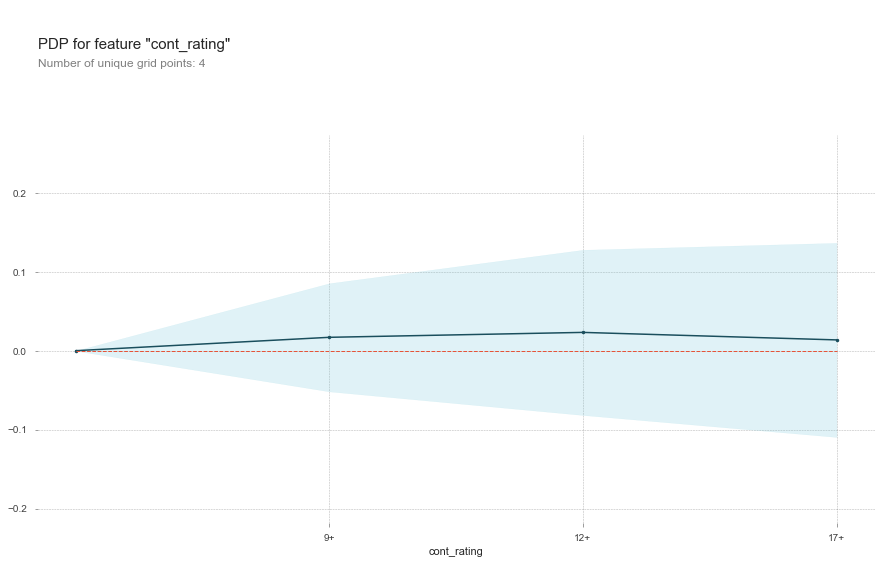

In [56]:
pdp.pdp_plot(pdp_dist, feature)

# Manually change the xticks labels
plt.xticks([ 2,3,4], [ '9+','12+','17+']);

In [57]:
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

In [58]:
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.771718	validation_1-auc:0.740875
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.781021	validation_1-auc:0.752274
[2]	validation_0-auc:0.784201	validation_1-auc:0.758504
[3]	validation_0-auc:0.787379	validation_1-auc:0.763522
[4]	validation_0-auc:0.787757	validation_1-auc:0.766899
[5]	validation_0-auc:0.791991	validation_1-auc:0.771809
[6]	validation_0-auc:0.79185	validation_1-auc:0.771345
[7]	validation_0-auc:0.793031	validation_1-auc:0.770266
[8]	validation_0-auc:0.795111	validation_1-auc:0.769883
[9]	validation_0-auc:0.795597	validation_1-auc:0.771722
[10]	validation_0-auc:0.795288	validation_1-auc:0.769152
[11]	validation_0-auc:0.796596	validation_1-auc:0.76973
[12]	validation_0-auc:0.796687	validation_1-auc:0.768129
[13]	validation_0-auc:0.796514	validation_1-auc:0.765968
[14]	validation_0-auc:0.796624	validation_1-auc:0.766449


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

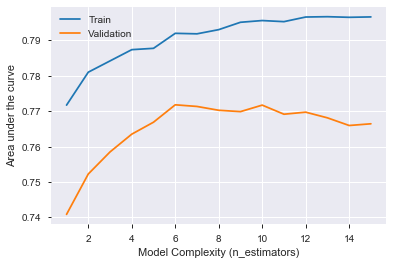

In [59]:
results = model.evals_result()
train_error = results['validation_0']['auc']
val_error = results['validation_1']['auc']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Area under the curve')
plt.xlabel('Model Complexity (n_estimators)')

plt.legend();

In [60]:
X_test=X_test.drop(columns='vpp_lic')

In [61]:
X_train.shape

(3325, 10)

In [62]:
X_val.shape

(832, 10)

In [63]:
X_test.shape

(1040, 10)

In [64]:
row=X_test.iloc[[88]]
row

,id,size_bytes,price,rating_count_tot,rating_count_ver,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating,prime_genre
5025,1086391724,71102464,0.0,375,18,37,1,1,9+,Utilities


In [65]:
import shap
explainer=shap.TreeExplainer(model)
row_processed=processor.transform(row)
shap_values=explainer.shap_values(row_processed)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row, 
    link='logit'
)

In [66]:
# webapp
features=['cont_rating','prime_genre']
target=['rating']
app_X_train=X_train[features]
app_y_train=y_train
app_X_test=X_test[features]

In [67]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1)
)

pipeline.fit(app_X_train,app_y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['cont_rating', 'prime_genre'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'cont_rating',
                                          'data_type': dtype('O'),
                                          'mapping': 4+     1
9+     2
12+    3
17+    4
NaN   -2
dtype: int64},
                                         {'col': 'prime_genre',
                                          'data_type': dtype('O'),
                                          'mapping': Games                 1
Utilities             2
Lifestyle             3
Entertainmen...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',

In [68]:
from joblib import dump
dump(pipeline,'webapp.joblib',compress=True)

['webapp.joblib']

In [69]:
import joblib
import sklearn
import xgboost
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')

joblib==0.14.0
scikit-learn==0.22
category_encoders==2.1.0
xgboost==0.90


In [70]:
def predict(cont_rating, prime_genre):
    df = pd.DataFrame(
        columns=['cont_rating', 'prime_genre'], 
        data=[[cont_rating, prime_genre]]
    )
    y_pred=pipeline.predict(df)
    return y_pred

In [71]:
predict('4+','Games')

array([0])